In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [14]:
import sys
import six
print("keras:", keras.__version__)
print("tf:", tf.__version__)
print("python:", sys.version_info)
print("six:", six.__version__)

keras: 2.1.2
tf: 1.4.0
python: sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)
six: 1.11.0


In [13]:
model = keras.models.load_model('snapshots/resnet50_coco_best_v1.2.1.h5', custom_objects=custom_objects)
#model = keras.models.load_model('snapshots/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)

#Kai - note that latest version of model (v1.2.2) failed to load because of TypeError: Fetch argument None has invalid type <class 'NoneType'>
#      filed bug report https://github.com/fizyr/keras-retinanet/issues/177

#print(model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.2-py3.6.egg\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Initialize data generators

In [3]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CocoGenerator(
    'C:\\Users\\Kai\\study\\mlData\\coco',
    'val2017',
    val_image_data_generator,
    batch_size=1,
)
index = 0

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


## Run detection on example

processing time:  0.72196364402771


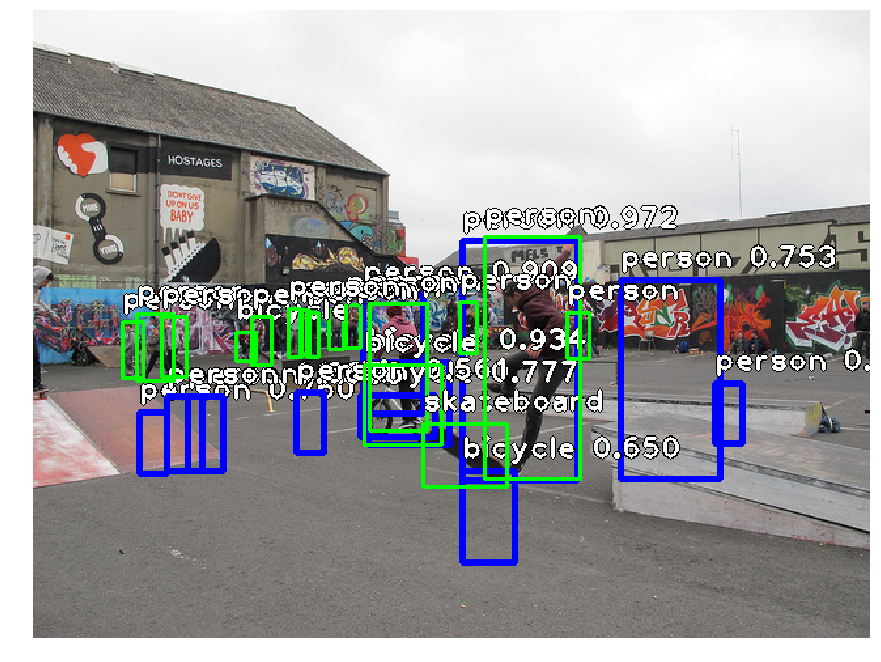

In [7]:
# load image
image = val_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[:, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()